Ch1

In [2]:
import pandas as pd
data_raw = pd.read_csv('data_ml.csv')
idx_date = data_raw.index[(
    data_raw['date'] > '1999-12-31') & (
    data_raw['date'] < '2019-01-01')].tolist()
#날짜를 받기 위한 인덱스 생성
data_ml = data_raw.iloc[idx_date]
#날짜 인덱스에 따라 데이터셋 필터링
data_ml.iloc[0:6, 0:6]

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover
0,13,2006-12-31,0.25,0.33,0.27,0.22
1,13,2007-01-31,0.25,0.32,0.28,0.22
2,13,2007-02-28,0.26,0.30,0.30,0.22
3,17,2015-03-31,0.73,0.64,0.70,0.40
4,17,2015-04-30,0.72,0.62,0.66,0.40
5,17,2015-05-31,0.71,0.63,0.64,0.40


Text(0, 0.5, 'nb_assets')

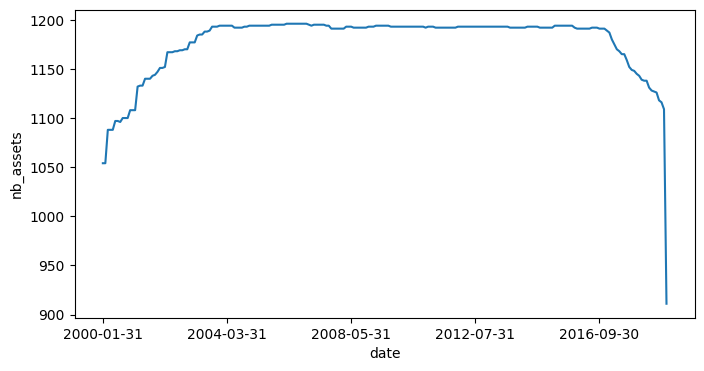

In [3]:
import matplotlib.pyplot as plt
pd.Series(data_ml.groupby('date').size()).plot(figsize=(8,4))
# 각 날짜별 자산 개수 세기
plt.ylabel('nb_assets')
# y축 제목을 추가한 후 그래프 그리기

In [4]:
features = list(data_ml.iloc[:, 3:95].columns)
# 특성의 열 이름 저장 
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd",
                  "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]

Text(0, 0.5, 'count')

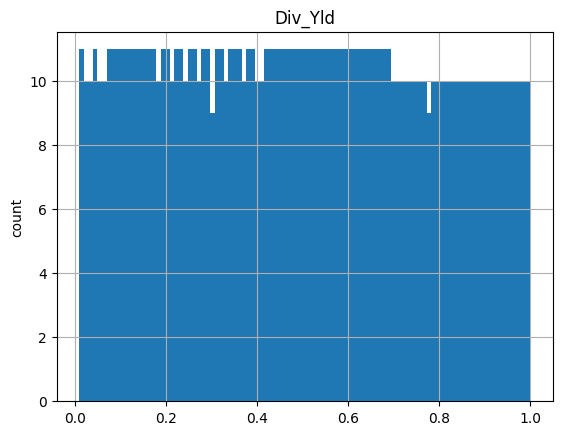

In [5]:
# 특성 Div_Yld 열
col_feat_Div_Yld = data_ml.columns.get_loc('Div_Yld')
# 필터링할 부울 인덱스 생성
is_custom_date = data_ml['date'] =='2000-02-29'
# 히스토그램 사용
data_ml[is_custom_date].iloc[:, [col_feat_Div_Yld]].hist(bins=100)
plt.ylabel('count')

'매수' '유지' '매도' 같은 범주를 예측 시 (분류 분석) 수치형 레이블이 아닌 범주형 레이블을 추가적으로 생성

In [6]:
df_median = []
df = []

import numpy as np
df_median = data_ml[['date', 'R1M_Usd', 'R12M_Usd']].groupby(
    ['date']).median()
df_median.rename(
    columns={"R1M_Usd": "R1M_Usd_median",
             "R12M_Usd": "R12M_Usd_median"}, inplace=True)

df = pd.merge(data_ml, df_median, how='left', on=['date'])

data_ml['R1M_Usd_C'] = np.where(
    df['R1M_Usd'] > df['R1M_Usd_median'], 1.0, 0.0)
data_ml['R12M_Usd_C'] = np.where(
    df['R12M_Usd'] > df['R12M_Usd_median'], 1.0, 0.0)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_28056\2378900137.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['R1M_Usd_C'] = np.where(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_28056\2378900137.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['R12M_Usd_C'] = np.where(


데이터셋 분리

In [7]:
sepration_date = "2014-01-15"
idx_train = data_ml.index[(data_ml['date']<sepration_date)].tolist()
idx_test = data_ml.index[(data_ml['date']>=sepration_date)].tolist()

자산 식별 코드 및 수익률 데이터프레임 같은 주요 변수를 따로 메모리에 보관  
후자의 계산을 간단하게 하기 위해 투자 유니버스를 축소해 데이터 포인트가 최대로 있는 종목들만 유지

In [8]:
stock_ids_short = []
stock_days = []

# 각 주식별 데이터 포인트 개수 세기
stock_ids = data_ml['stock_id'].unique()
stock_days = data_ml[['date', 'stock_id']].groupby(
    ['stock_id']).count().reset_index()

# 데이터가 모두 있는 주식을 리스트로 변환
stock_ids_short = stock_days.loc[
    stock_days['date'] == (stock_days['date'].max())]
stock_ids_short = stock_ids_short['stock_id'].unique()
is_stock_ids_short = data_ml['stock_id'].isin(stock_ids_short)
returns = data_ml[is_stock_ids_short].pivot(
    index='date', columns='stock_id', values='R1M_Usd'
)

Ch3

사이즈 팩터 포트폴리오 계산

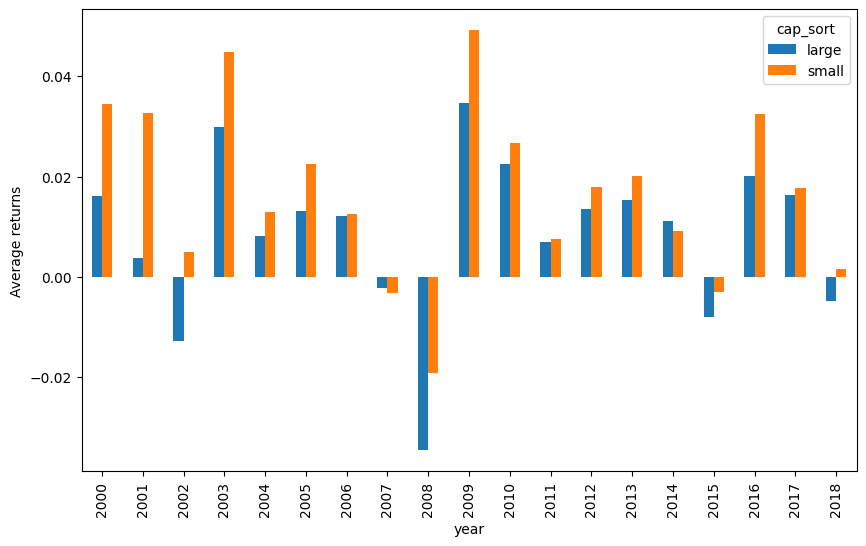

In [66]:
df_median = []
df = []

df_median = data_ml[['date', 'Mkt_Cap_12M_Usd']].groupby(
    ['date']).median().reset_index()
df_median.rename(
    columns = {'Mkt_Cap_12M_Usd' : 'cap_median'}, inplace=True)

# 연도 및 시가총액 로직 설정 후 그룹화
df = pd.merge(
    data_ml[["date", 'Mkt_Cap_12M_Usd', 'R1M_Usd']],
    df_median, how='left', on=['date'])
df = df.groupby(
    [pd.to_datetime(df['date']).dt.year, np.where(
        df['Mkt_Cap_12M_Usd'] > df['cap_median'],
        'large', 'small')])['R1M_Usd'].mean().reset_index()
df.rename(columns = {'level_1' : 'cap_sort'}, inplace=True)
df.pivot(index='date', columns='cap_sort', values='R1M_Usd').plot.bar(figsize = (10,6))
plt.ylabel('Average returns')
plt.xlabel('year')

# 임시 데이터프레임을 제거해 가볍게 만들자!
df_median = []
df = []


In [ ]:
# 사이즈 팩터 : 소형주 대 대형주 평균 수익률

주요 이상 현상 - 케네스 프렌치의 데이터 라이브러리 / AQR 저장소.  
이 책에서는 케네스 프렌치의 데이터

In [45]:
import urllib.request
min_date = 196307
max_date = 202003
# 다운로드 URL
#ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp"
#ff_url += "/F-F_Research_Data_5_Factors_2x3_CSV.zip"
# 다운로드
#urllib.request.urlretrieve(ff_url, 'factors.zip')

df_ff = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv',
                    header=2, sep=',', quotechar='"')
df_ff.rename(columns = {'Unnamed: 0':'date'}, inplace=True)
df_ff.rename(columns = {'Mkt-RF':'MKT_RF'}, inplace=True)

# 숫자형으로 변환할 열 지정
cols_to_convert = ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
df_ff['date'] = pd.to_numeric(df_ff['date'], errors='coerce')

# 각 열을 숫자형으로 변환 (숫자가 아닌 값은 NaN으로 처리)
df_ff[cols_to_convert] = df_ff[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# 열 값 스케일링 (백분율 -> 소수점 변환)
df_ff[cols_to_convert] = df_ff[cols_to_convert] / 100.0

#df_ff[['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] = df_ff[['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].values/100.0 #수익률 스케일링
idx_ff = df_ff.index[(df_ff['date']>=min_date) & (
    df_ff['date'] <= max_date)].tolist()
FF_factors = df_ff.iloc[idx_ff]
FF_factors['year'] = FF_factors.date.astype(str).str[:4]
FF_factors.iloc[1:6,0:7].head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_28056\3024586893.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FF_factors['year'] = FF_factors.date.astype(str).str[:4]


,date,MKT_RF,SMB,HML,RMW,CMA,RF
1,196308.0,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025
2,196309.0,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027
3,196310.0,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029
4,196311.0,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027
5,196312.0,0.0183,-0.0210,-0.0002,0.0003,-0.0007,0.0029


In [ ]:
""" 
MKT_RF : Market Risk Premium (시장 위험 프리미엄)
SMB : Small Minus Big (사이즈 팩터)
HML : High Minus Low (밸류 팩터)
RMW : Robust Minus Weak profit (수익성)
CMA : Conservative Minus Aggressive (투자)
RF : Risk Free Rate (무위험 수익률)
"""

5가지 공통 팩터에 대한 각 연도별 집계 월평균 수익률

Text(0.5, 0, 'date')

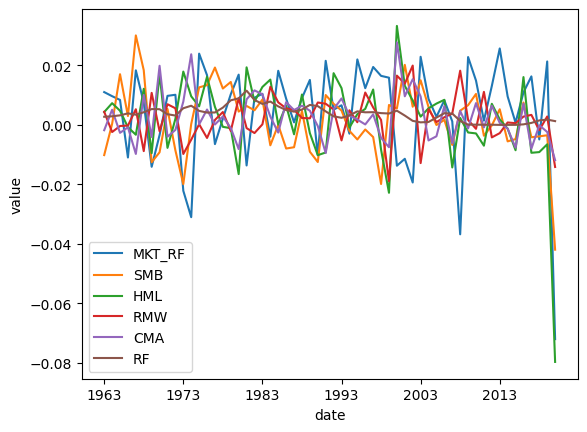

In [46]:
# 연도 및 시가 총액 로직 설정해 그룹화하기
FF_factors.iloc[:, 1:7].groupby(FF_factors['year']).mean().plot()
# 연도와 팩터별로 그룹화 후 평균 수익률 계산
plt.ylabel('value')
plt.xlabel('date')

3.2.4 파마-맥베스 회귀  
위험 프리미엄에 대한 2단계 회귀 분석

In [50]:
from pandas.tseries.offsets import MonthEnd
stocks_list = list(returns.columns)
FF_factors['date'] = pd.to_datetime(
    FF_factors['date'], format = '%Y-%m-%d') + MonthEnd(0)
FF_factors['date'] = FF_factors['date'].dt.date
FF_factors['date'] = FF_factors['date'].astype(str)
data_FM = pd.merge(returns.iloc[:,0].reset_index(),
                   FF_factors.iloc[:, 0:7], how='left', on=['date'])
data = FF_factors
data_FM.dropna(inplace=True)

import statsmodels.api as sm
results_params = []
reg_result = []
df_res_full = []
for i in range(len(returns.columns)):
    Y = returns.iloc[:,i].shift(-1).reset_index()
    Y = Y.drop(columns=['date'])
    Y.dropna(inplace=True)
    results=sm.OLS(endog=Y, exog=sm.add_constant(
        data_FM.iloc[0:227, 2:7])).fit()
    results_params = results.params
    reg_result_tmp = pd.DataFrame(results_params)
    reg_result_tmp['stock id'] = stocks_list[i]
    df_res_full.append(reg_result_tmp)
df_res_full = pd.concat(df_res_full)
df_res_full.reset_index(inplace=True)
df_res_full.rename(columns={"index" : "factors_name", 0 :
    "betas"}, inplace=True)
df_res_full_mat = df_res_full.pivot(index='stock id',
                                    columns='factors_name', values = 'betas')
column_names_inverted = ["const", "MKT_RF", "SMB", "HML", "RMW", "CMA"]
reg_result = df_res_full_mat.reindex(columns=column_names_inverted)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_28056\659410358.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FF_factors['date'] = pd.to_datetime(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_28056\659410358.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FF_factors['date'] = FF_factors['date'].dt.date
C:\Users\Administrator\AppData\Local\Temp\ipykernel_28056\659410358.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [53]:
returns_trsp = returns.transpose()
df_2nd_pass = pd.concat([reg_result.iloc[:, 1:6], returns.transpose()], axis=1)
df_2nd_pass.head()

,MKT_RF,SMB,HML,RMW,CMA,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31
1,0.135925,0.088914,-0.394731,0.508615,0.478881,-0.036,0.263,0.031,0.448,-0.097,...,0.173,-0.042,-0.038,0.000,-0.077,-0.002,-0.155,0.014,-0.110,0.082
3,-0.234715,-0.121142,0.088811,-0.205260,-0.344264,0.077,-0.024,0.018,0.027,0.050,...,-0.039,0.030,-0.028,-0.039,0.033,-0.049,-0.070,0.036,-0.070,0.030
4,-0.005960,-0.047208,0.013282,-0.310708,-0.034570,-0.016,0.000,0.153,-0.011,0.014,...,0.071,-0.024,0.059,0.029,-0.004,0.036,-0.025,0.000,-0.088,0.043
7,-0.338030,-0.019414,-0.018568,-0.261689,0.240674,-0.009,0.027,0.000,-0.017,0.018,...,0.030,0.100,0.036,-0.005,0.022,-0.068,-0.052,0.007,-0.066,0.131
9,-0.203108,0.266002,0.173311,-0.170657,0.022076,0.032,0.076,-0.025,-0.022,-0.121,...,0.046,0.047,0.000,0.064,-0.137,-0.028,-0.098,-0.018,-0.099,0.112


2번째 회귀분석

In [54]:
betas = df_2nd_pass.iloc[:, 0:5]
date_list = list(returns_trsp.columns)
results_params = []
reg_result = []
df_res_full = []
for j in range(len(returns_trsp.columns)):
    Y = returns_trsp.iloc[:,j]
    results = sm.OLS(endog=Y, exog=sm.add_constant(betas)).fit()
    results_params = results.params
    reg_result_tmp = pd.DataFrame(results_params)
    reg_result_tmp['date'] = date_list[j]
    df_res_full.append(reg_result_tmp)
    
df_res_full = pd.concat(df_res_full)
df_res_full.reset_index(inplace=True)
gammas = df_res_full

gammas.rename(columns={"index": "factors_name", 0: "betas"}, inplace=True)
gammas_mat = gammas.pivot(index='date', columns='factors_name', values='betas')
column_names_inverted = ["const", "MKT_RF", "SMB", "HML", "RMW", "CMA"]
gammas_mat = gammas_mat.reindex(columns=column_names_inverted)
gammas_mat.head()

factors_name,const,MKT_RF,SMB,HML,RMW,CMA
date,,,,,,
2000-01-31,0.016540,-0.017508,-0.002414,0.028257,0.075829,0.026574
2000-02-29,0.041179,0.004853,-0.000145,-0.053036,-0.092594,0.034231
2000-03-31,0.014423,0.021418,0.054148,-0.071231,-0.099411,-0.049923
2000-04-30,0.133256,0.150161,-0.458967,0.281929,0.349697,-0.071416
2000-05-31,0.012784,-0.029657,-0.059283,0.070395,0.105902,0.069507


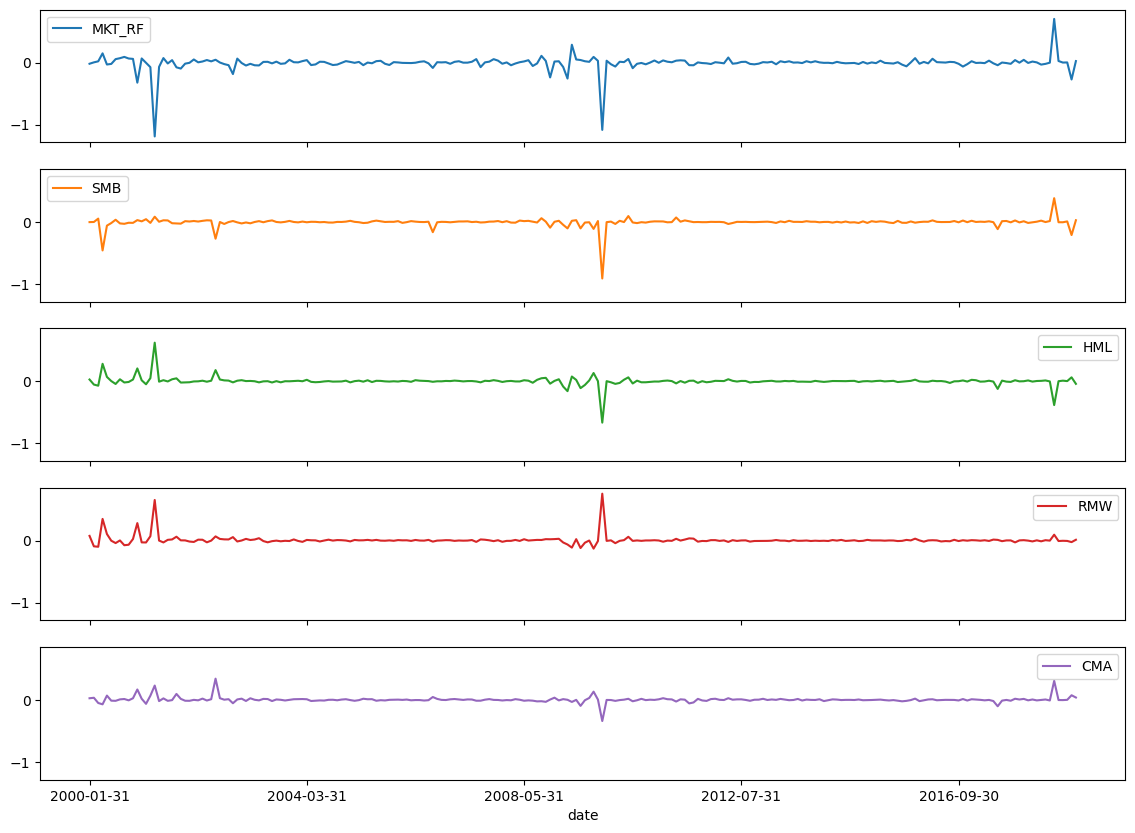

In [56]:
gammas_mat.iloc[:, 1:6].plot(
    figsize=(14,10), subplots=True, sharey=True, sharex=True
)
plt.show()

3.2.5 팩터 경쟁

중복 팩터 거르기 (파마/프렌치) : 각 팩터를 다른 모든 팩터와 비교하는 회귀분석

In [58]:
df_res_full=[]
for i in range(0,5):
    factors_list_full = ["MKT_RF", "SMB", "HML", "RMW", "CMA"]
    facotrs_list_tmp = factors_list_full
    Y= FF_factors[factors_list_full[i]]
    facotrs_list_tmp.remove(factors_list_full[i])
    data=FF_factors[facotrs_list_tmp]
    results=sm.OLS(endog=Y, exog=sm.add_constant(data)).fit()
    results_params = results.params
    reg_result_tmp = pd.DataFrame(results_params)
    reg_result_tmp['factor_mnemo'] = Y.name #factor_mnemo : 종속변수
    reg_result_tmp['pvalue'] = results.pvalues
    df_res_full.append(reg_result_tmp)
    
df_res_full = pd.concat(df_res_full)
df_res_full.reset_index(inplace=True)
df_res_full.rename(columns={0: "coeff"}, inplace=True)

0 ~ 0.001 ~ 0.01 ~ 0.05 pvalue 설정

In [60]:
df_significance = df_res_full
conditions = [(df_significance['pvalue'] > 0) & (
    df_significance['pvalue'] < 0.001),
    (df_significance['pvalue']> 0.001) & (df_significance['pvalue'] < 0.01),
    (df_significance['pvalue']> 0.01) & (df_significance['pvalue'] < 0.05),
    (df_significance['pvalue'] > 0.05)]

valuest = ['(***)', '(**)', '(*)', 'na']

# 새로운 행 생성 및 값 할당을 위해 np.select 사용
df_significance['significance'] = np.select(conditions, valuest, default='na').astype(str)
df_significance['coeff'] = round(df_significance.coeff, 3)
df_significance['coeff_stars'] = df_significance.coeff.astype(str) + '  ' + df_significance.significance

# 적절한 형태로 업데이트한 데이터프레임 표시
new_index = ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA']
df_significance_pivot = df_significance.pivot(
    index='index', columns='factor_mnemo', values='coeff_stars').transpose()
df_significance_pivot = df_significance_pivot.reindex(
    columns=column_names_inverted) 
df_significance_pivot.reindex(new_index)

index,const,MKT_RF,SMB,HML,RMW,CMA
factor_mnemo,,,,,,
MKT_RF,0.008 (***),NaN,0.27 (***),0.167 (*),-0.358 (***),-0.993 (***)
SMB,0.003 (*),0.137 (***),NaN,0.114 (*),-0.432 (***),-0.167 (*)
HML,-0.001 na,0.048 (*),0.064 (*),NaN,0.191 (***),1.039 (***)
RMW,0.004 (***),-0.093 (***),-0.222 (***),0.174 (***),NaN,-0.326 (***)
CMA,0.003 (***),-0.119 (***),-0.039 (*),0.435 (***),-0.15 (***),NaN


3.4 핫한 주제들 : 모멘텀, 타이밍, ESG

3.4.1 팩터 모멘텀

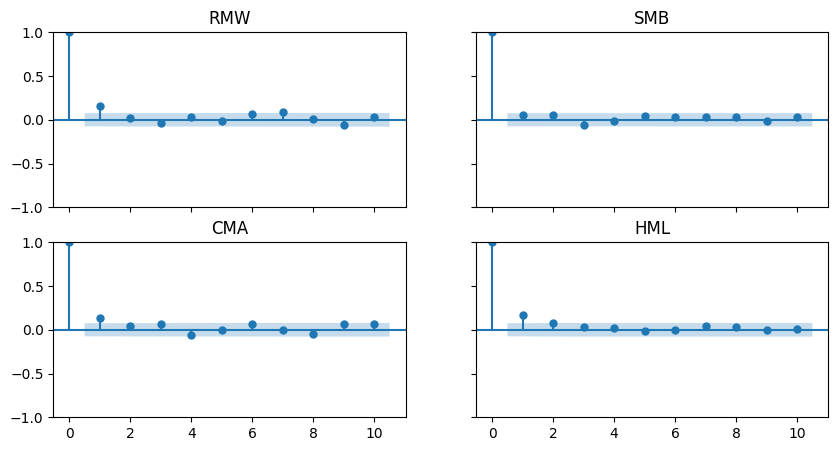

In [63]:
flg, ax = plt.subplots(2,2,figsize=(10,5), sharex='all', sharey='all')
sm.graphics.tsa.plot_acf(FF_factors.RMW, lags=10, ax=ax[0,0], title='RMW')
sm.graphics.tsa.plot_acf(FF_factors.CMA, lags=10, ax=ax[1,0], title='CMA')
sm.graphics.tsa.plot_acf(FF_factors.SMB, lags=10, ax=ax[0,1], title='SMB')
sm.graphics.tsa.plot_acf(FF_factors.HML, lags=10, ax=ax[1,1], title='HML')
plt.show()

3.4.2 팩터 타이밍 , 3.4.3 ESG 의견 혼재, 둘 모두 적용은 가능. 기준은 좀 다름

3.6 코딩예제

1 성장주 대 가치주 포트폴리오의 연간 수익률, 즉 장부가 대비 주가 비율이 중간값 이상인 기업의 평균 수익률을 계산하라. (데이터셋에서 해당 변수는 'Pb')

,date,val_sort,R1M_Usd
0,2000,Growth,0.016787
1,2000,Value,0.033269
2,2001,Growth,0.005628
3,2001,Value,0.030111
4,2002,Growth,-0.014095


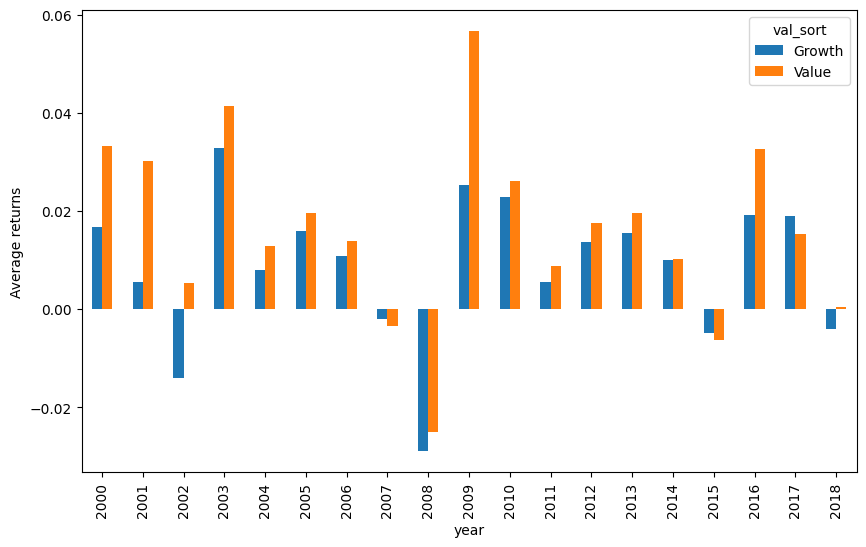

In [70]:
df_median = []
df = []

df_median = data_ml[['date', 'Pb']].groupby(
    ['date']).median().reset_index()
df_median.rename(
    columns = {'Pb' : 'Pb_median'}, inplace=True)

# 연도 및 시가총액 로직 설정 후 그룹화
df = pd.merge(
    data_ml[["date", 'Pb', 'R1M_Usd']],
    df_median, how='left', on=['date'])
df = df.groupby(
    [pd.to_datetime(df['date']).dt.year, np.where(
        df['Pb'] > df['Pb_median'],
        'Growth', 'Value')])['R1M_Usd'].mean().reset_index()
df.rename(columns = {'level_1' : 'val_sort'}, inplace=True)
df.pivot(index='date', columns='val_sort', values='R1M_Usd').plot.bar(figsize = (10,6))
plt.ylabel('Average returns')
plt.xlabel('year')

# 임시 데이터프레임을 제거해 가볍게 만들자!
#df_median = []
#df = []
df.head()

2. 동일한 문제, 월별 수익률 계산 후 해당 포트폴리오의 시간경과에 따른 값을 그래프로 시각화.